## CNN

(4000, 3)
(4000, 128, 128)
(4000, 4)
model name: model_3200train_150ep_CNN
mps
model_3200train_150ep_CNN
RVECNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=8196, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (softplus): Softplus(beta=1, threshold=20)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
)
Epoch [1/150], Batch [0/13], Loss: 0.410210, Avg Batch Time: 0.271, Avg Data Time: 0.057
Epoch [2/150], Batch [0/13], Loss: 0.029993, Avg Batch Time: 0.025, Avg Data Time: 0.003
Epoch [3/150], Batch [0/13], Loss: 0.029014, Avg Batch Time: 0.024, Avg Data Time: 0.002
Epoch [4/150], Batch [0/13], Loss: 0.035461, Avg Batch Time: 0.024, Avg Data Time: 0.002
Epoch [5/150], Batch [0/13], Loss: 0

Epoch [86/150], Batch [0/13], Loss: 0.000579, Avg Batch Time: 0.025, Avg Data Time: 0.004
Epoch [87/150], Batch [0/13], Loss: 0.000561, Avg Batch Time: 0.026, Avg Data Time: 0.004
Epoch [88/150], Batch [0/13], Loss: 0.000429, Avg Batch Time: 0.025, Avg Data Time: 0.003
Epoch [89/150], Batch [0/13], Loss: 0.000580, Avg Batch Time: 0.025, Avg Data Time: 0.003
Epoch [90/150], Batch [0/13], Loss: 0.000586, Avg Batch Time: 0.025, Avg Data Time: 0.004
Early stopping!


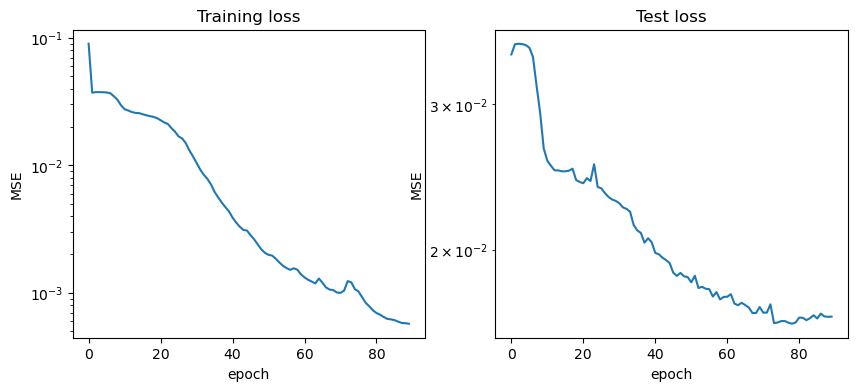

In [5]:
import torch
import torch.nn as nn
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.preprocessing import MinMaxScaler

# Global variables
global device, print_freq
print_freq = 300
device = torch.device('mps')

WORKING_PATH = 'CNNResult/'
os.makedirs(WORKING_PATH, exist_ok=True)

# CNN Model
class RVECNN(torch.nn.Module):
    def __init__(self):
        super(RVECNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.fc1 = torch.nn.Linear(8196, 256)
        self.fc2 = torch.nn.Linear(256, 3)
        self.relu = torch.nn.LeakyReLU()
        self.softplus = torch.nn.Softplus()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = torch.nn.Dropout(p=0.7)

    def forward(self, x, props):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.reshape(x.size(0), -1)
        x = torch.cat((props, x), 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softplus(x)
        return x

# Dataset class
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, inp, props, out):
        self.inp = inp
        self.props = props
        self.out = out

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, index):
        return self.inp[index], self.props[index], self.out[index]

# AverageMeter class
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Training function
def train_NN(model, net_info, train_loader, test_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    test_losses = []
    train_losses = []
    best_model = copy.deepcopy(model)
    best_loss = 1e10
    es = 0

    for epoch in range(net_info['num_epochs']):
        model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        start = time.time()

        for i, (input_, props, output) in enumerate(train_loader):
            input_, props, output = input_.to(device), props.to(device), output.to(device)
            data_time.update(time.time() - start)
            optimizer.zero_grad()
            outputs = model(input_, props)
            loss = criterion(outputs, output)
            loss.backward()
            optimizer.step()
            losses.update(loss.item(), input_.size(0))
            batch_time.update(time.time() - start)
            start = time.time()
            if i % print_freq == 0:
                print(f'Epoch [{epoch+1}/{net_info["num_epochs"]}], '
                      f'Batch [{i}/{len(train_loader)}], '
                      f'Loss: {loss.item():.6f}, '
                      f'Avg Batch Time: {batch_time.avg:.3f}, '
                      f'Avg Data Time: {data_time.avg:.3f}')

        train_losses.append(losses.avg)
        model.eval()
        val_losses = AverageMeter()

        with torch.no_grad():
            for i, (input_, props, output) in enumerate(test_loader):
                input_, props, output = input_.to(device), props.to(device), output.to(device)
                outputs = model(input_, props)
                loss = criterion(outputs, output)
                val_losses.update(loss.item(), input_.size(0))

        test_losses.append(val_losses.avg)
        if val_losses.avg < best_loss:
            best_loss = val_losses.avg
            best_model = copy.deepcopy(model)
            es = 0
        else:
            es += 1
            if es > net_info['early_stop']:
                print('Early stopping!')
                break
        scheduler.step()

    model.load_state_dict(best_model.state_dict())
    torch.save(model.state_dict(), WORKING_PATH + 'best_model_' + str(net_info['model_version']) + '_augmented_' + str(net_info['augment']) + '.pth.tar')
    
    np.array(test_losses).tofile(WORKING_PATH + 'val_loss' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")
    np.array(train_losses).tofile(WORKING_PATH + 'train_loss' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Test loss')
    ax[1].set_yscale('log')
    plt.show()
    return model

# Main script
def main_program(inp, props, out, trainer_info, model_name):
    num_sample = trainer_info['train_size']
    inp_train = inp[0:num_sample, :, :, :]
    out_train = out[0:num_sample]
    props_train = props[0:num_sample]
    training_set = MyDataset(inp_train, props_train, out_train)

    inp_test = inp[num_sample:inp.shape[0], :, :, :]
    out_test = out[num_sample:inp.shape[0]]
    props_test = props[num_sample:inp.shape[0]]
    test_set = MyDataset(inp_test, props_test, out_test)

    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = RVECNN().to(device)
    print(model_name)
    print(model)

    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), WORKING_PATH + model_name)

    return model

if __name__ == "__main__":
    # load data
    stiffness = np.load(file='data/cnn_homogenized_stiffness_part2.npy')
    rve_masks = np.load(file='data/cnn_rve_masks_part2_rve.npy')
    mat_props = np.load(file='data/cnn_mat_props_part2.npy')

    # normalize mat_props
    props_scaler = MinMaxScaler()
    mat_props = props_scaler.fit_transform(mat_props)
    joblib.dump(props_scaler, WORKING_PATH + 'props_scaler.pkl')
    stiffness_scaler = MinMaxScaler()
    stiffness = stiffness_scaler.fit_transform(stiffness)
    joblib.dump(stiffness_scaler, WORKING_PATH + 'stiffness_scaler.pkl')

    print(stiffness.shape)
    print(rve_masks.shape)
    print(mat_props.shape)

    rve_tensor = torch.from_numpy(rve_masks).float()
    rve_tensor = rve_tensor.unsqueeze(1)
    stiffness_tensor = torch.from_numpy(stiffness).float()
    mat_props_tensor = torch.from_numpy(mat_props).float()
    size = int(stiffness_tensor.shape[0]*0.8)
    is_augment = False
    trainer_info = {
        'num_epochs': 150,
        'train_size': size,
        'train_batch': 256,
        'test_batch': 512,
        'lr0': 5e-4,
        'when_decay': 50,
        'lr_decay': 0.1,
        'early_stop': 10,
        'augment': is_augment,
        'model_version': '1'
    }

    note = 'CNN'

    model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['num_epochs']) + 'ep_' + note

    print('model name: ' + model_name)
    print(device)

    CNNmodel = main_program(rve_tensor, mat_props_tensor, stiffness_tensor, trainer_info, model_name)


## KAN Conv 
Replace convolution layers with KAN convolution layers

(4000, 3)
(4000, 128, 128)
(4000, 4)
model name: model_3200train_150ep_KAN
cpu
model_3200train_150ep_KAN
RVEKAN(
  (conv1): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv2): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (fc1): Linear(in_features=260, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (softplus): Softplus(beta=1, threshold=20)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
)
Epoch [1/150], Batch [0/13], Loss: 0.417360, Avg Batch Time: 2.910, Avg Data Time: 0.002
Epoch [2/150], Batch [0/13], Loss: 0.232809, Avg Batch Time: 2.859, Avg Data Time: 0.002
Epoch [3

Epoch [84/150], Batch [0/13], Loss: 0.002578, Avg Batch Time: 2.970, Avg Data Time: 0.002
Epoch [85/150], Batch [0/13], Loss: 0.002092, Avg Batch Time: 2.978, Avg Data Time: 0.003
Epoch [86/150], Batch [0/13], Loss: 0.001938, Avg Batch Time: 2.962, Avg Data Time: 0.003
Epoch [87/150], Batch [0/13], Loss: 0.001972, Avg Batch Time: 3.101, Avg Data Time: 0.003
Epoch [88/150], Batch [0/13], Loss: 0.002209, Avg Batch Time: 2.887, Avg Data Time: 0.003
Epoch [89/150], Batch [0/13], Loss: 0.001916, Avg Batch Time: 3.022, Avg Data Time: 0.003
Epoch [90/150], Batch [0/13], Loss: 0.001939, Avg Batch Time: 2.979, Avg Data Time: 0.003
Epoch [91/150], Batch [0/13], Loss: 0.002252, Avg Batch Time: 3.083, Avg Data Time: 0.003
Epoch [92/150], Batch [0/13], Loss: 0.002019, Avg Batch Time: 2.960, Avg Data Time: 0.002
Epoch [93/150], Batch [0/13], Loss: 0.002342, Avg Batch Time: 2.976, Avg Data Time: 0.003
Epoch [94/150], Batch [0/13], Loss: 0.002549, Avg Batch Time: 2.956, Avg Data Time: 0.002
Epoch [95/

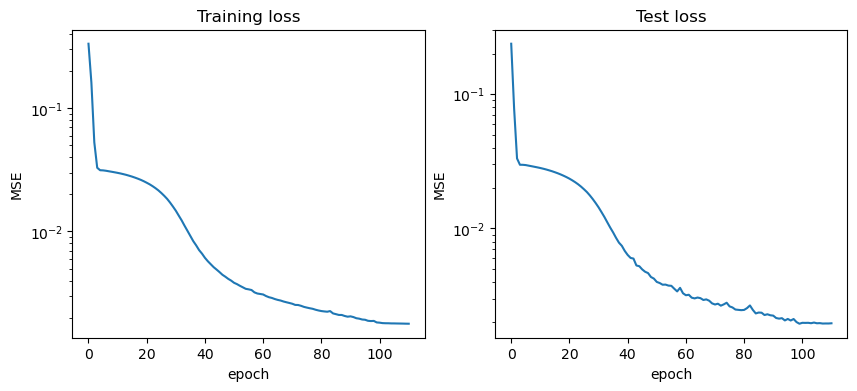

In [8]:
import torch
import torch.nn as nn
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from KANConv import KAN_Convolutional_Layer

# Global variables
global device, print_freq
print_freq = 300
device = torch.device('cpu')

WORKING_PATH = 'KANResult/'
os.makedirs(WORKING_PATH, exist_ok=True)

# RVEKAN Model
class RVEKAN(torch.nn.Module):
    def __init__(self):
        super(RVEKAN, self).__init__()
        self.conv1 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.fc1 = torch.nn.Linear(260, 256)  # Adjusted input size to 260
        self.fc2 = torch.nn.Linear(256, 3)
        self.relu = torch.nn.LeakyReLU()
        self.softplus = torch.nn.Softplus()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = torch.nn.Dropout(p=0.7)

    def forward(self, x, props):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.reshape(x.size(0), -1)
        #print("Shape after conv layers and flattening: ", x.shape)
        #print("Shape of props: ", props.shape)
        x = torch.cat((props, x), 1)
        #print("Shape after concatenation: ", x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softplus(x)
        return x

# Training function
def train_NN(model, net_info, train_loader, test_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    test_losses = []
    train_losses = []
    best_model = copy.deepcopy(model)
    best_loss = 1e10
    es = 0

    for epoch in range(net_info['num_epochs']):
        model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        start = time.time()

        for i, (input_, props, output) in enumerate(train_loader):
            input_, props, output = input_.to(device), props.to(device), output.to(device)
            data_time.update(time.time() - start)
            optimizer.zero_grad()
            outputs = model(input_, props)
            loss = criterion(outputs, output)
            loss.backward()
            optimizer.step()
            losses.update(loss.item(), input_.size(0))
            batch_time.update(time.time() - start)
            start = time.time()
            if i % print_freq == 0:
                print(f'Epoch [{epoch+1}/{net_info["num_epochs"]}], '
                      f'Batch [{i}/{len(train_loader)}], '
                      f'Loss: {loss.item():.6f}, '
                      f'Avg Batch Time: {batch_time.avg:.3f}, '
                      f'Avg Data Time: {data_time.avg:.3f}')

        train_losses.append(losses.avg)
        model.eval()
        val_losses = AverageMeter()

        with torch.no_grad():
            for i, (input_, props, output) in enumerate(test_loader):
                input_, props, output = input_.to(device), props.to(device), output.to(device)
                outputs = model(input_, props)
                loss = criterion(outputs, output)
                val_losses.update(loss.item(), input_.size(0))

        test_losses.append(val_losses.avg)
        if val_losses.avg < best_loss:
            best_loss = val_losses.avg
            best_model = copy.deepcopy(model)
            es = 0
        else:
            es += 1
            if es > net_info['early_stop']:
                print('Early stopping!')
                break
        scheduler.step()

    model.load_state_dict(best_model.state_dict())
    torch.save(model.state_dict(), WORKING_PATH + 'best_model_' + str(net_info['model_version']) + '_augmented_' + str(net_info['augment']) + '.pth.tar')
    
    np.array(test_losses).tofile(WORKING_PATH + 'val_loss' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")
    np.array(train_losses).tofile(WORKING_PATH + 'train_loss' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Test loss')
    ax[1].set_yscale('log')
    plt.show()
    return model

def main_program(inp, props, out, trainer_info, model_name):
    num_sample = trainer_info['train_size']
    inp_train = inp[0:num_sample, :, :, :]
    out_train = out[0:num_sample]
    props_train = props[0:num_sample]
    training_set = MyDataset(inp_train, props_train, out_train)

    inp_test = inp[num_sample:inp.shape[0], :, :, :]
    out_test = out[num_sample:inp.shape[0]]
    props_test = props[num_sample:inp.shape[0]]
    test_set = MyDataset(inp_test, props_test, out_test)

    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = RVEKAN().to(device)
    print(model_name)
    print(model)

    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), WORKING_PATH + model_name)

    return model

# Main script
if __name__ == "__main__":
    # load data
    stiffness = np.load(file='data/cnn_homogenized_stiffness_part2.npy')
    rve_masks = np.load(file='data/cnn_rve_masks_part2_rve.npy')
    mat_props = np.load(file='data/cnn_mat_props_part2.npy')

    # normalize mat_props
    props_scaler = MinMaxScaler()
    mat_props = props_scaler.fit_transform(mat_props)
    joblib.dump(props_scaler, WORKING_PATH + 'props_scaler.pkl')
    stiffness_scaler = MinMaxScaler()
    stiffness = stiffness_scaler.fit_transform(stiffness)
    joblib.dump(stiffness_scaler, WORKING_PATH + 'stiffness_scaler.pkl')

    print(stiffness.shape)
    print(rve_masks.shape)
    print(mat_props.shape)

    rve_tensor = torch.from_numpy(rve_masks).float()
    rve_tensor = rve_tensor.unsqueeze(1)
    stiffness_tensor = torch.from_numpy(stiffness).float()
    mat_props_tensor = torch.from_numpy(mat_props).float()
    size = int(stiffness_tensor.shape[0]*0.8)
    is_augment = False
    trainer_info = {
        'num_epochs': 150,
        'train_size': size,
        'train_batch': 256,
        'test_batch': 512,
        'lr0': 5e-4,
        'when_decay': 50,
        'lr_decay': 0.1,
        'early_stop': 10,
        'augment': is_augment,
        'model_version': '1'
    }

    note = 'KAN'

    model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['num_epochs']) + 'ep_' + note

    print('model name: ' + model_name)
    print(device)

    KANmodel = main_program(rve_tensor, mat_props_tensor, stiffness_tensor, trainer_info, model_name)


## KAN Conv + KAN Linear 

(4000, 3)
(4000, 128, 128)
(4000, 4)
model name: model_3200train_150ep_cnn
cpu
model_3200train_150ep_cnn
RVEKAN(
  (conv1): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv2): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0): KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (fc1): KANLinear(
    (base_activation): SiLU()
  )
  (fc2): KANLinear(
    (base_activation): SiLU()
  )
  (relu): LeakyReLU(negative_slope=0.01)
  (softplus): Softplus(beta=1, threshold=20)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.7, inplace=False)
)
Epoch [1/150], Batch [0/13], Loss: 0.363958, Avg Batch Time: 2.634, Avg Data Time: 0.003
Epoch [2/150], Batch [0/13], Loss: 0.289117, Avg Batch Time: 2.517, Avg Data Time: 0.002
Epoch [3/150], Batch [

Epoch [84/150], Batch [0/13], Loss: 0.000885, Avg Batch Time: 3.278, Avg Data Time: 0.002
Epoch [85/150], Batch [0/13], Loss: 0.000808, Avg Batch Time: 3.339, Avg Data Time: 0.003
Epoch [86/150], Batch [0/13], Loss: 0.000843, Avg Batch Time: 3.364, Avg Data Time: 0.003
Epoch [87/150], Batch [0/13], Loss: 0.000749, Avg Batch Time: 3.240, Avg Data Time: 0.003
Epoch [88/150], Batch [0/13], Loss: 0.000850, Avg Batch Time: 3.340, Avg Data Time: 0.003
Epoch [89/150], Batch [0/13], Loss: 0.000947, Avg Batch Time: 3.112, Avg Data Time: 0.003
Epoch [90/150], Batch [0/13], Loss: 0.000690, Avg Batch Time: 3.274, Avg Data Time: 0.003
Epoch [91/150], Batch [0/13], Loss: 0.000816, Avg Batch Time: 3.062, Avg Data Time: 0.003
Epoch [92/150], Batch [0/13], Loss: 0.000767, Avg Batch Time: 3.382, Avg Data Time: 0.003
Epoch [93/150], Batch [0/13], Loss: 0.000636, Avg Batch Time: 3.476, Avg Data Time: 0.003
Epoch [94/150], Batch [0/13], Loss: 0.000669, Avg Batch Time: 3.271, Avg Data Time: 0.003
Epoch [95/

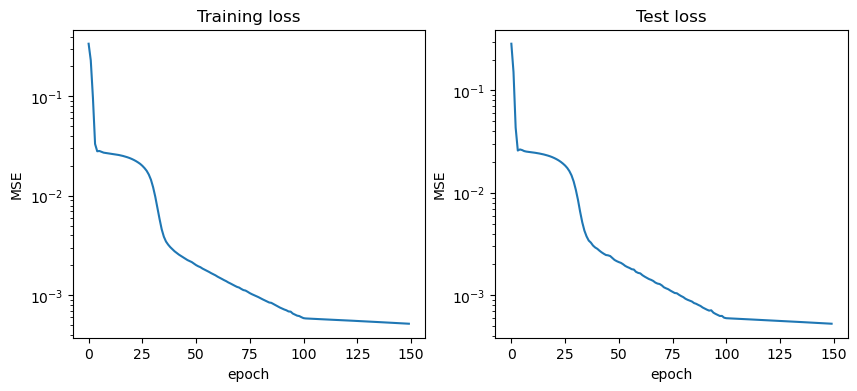

In [11]:
import torch
import torch.nn as nn
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from KANConv import KAN_Convolutional_Layer
from KANLinear import KANLinear

# Global variables
global device, print_freq
print_freq = 300
device = torch.device('cpu')

WORKING_PATH = 'KKANResult/'
os.makedirs(WORKING_PATH, exist_ok=True)

# RVEKAN Model
class RVEKAN(torch.nn.Module):
    def __init__(self):
        super(RVEKAN, self).__init__()
        self.conv1 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = KAN_Convolutional_Layer(n_convs=1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.fc1 = KANLinear(260, 256)  # Adjusted input size to 260
        self.fc2 = KANLinear(256, 3)
        self.relu = torch.nn.LeakyReLU()
        self.softplus = torch.nn.Softplus()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = torch.nn.Dropout(p=0.7)

    def forward(self, x, props):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.reshape(x.size(0), -1)
        #print("Shape after conv layers and flattening: ", x.shape)
        #print("Shape of props: ", props.shape)
        x = torch.cat((props, x), 1)
        #print("Shape after concatenation: ", x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softplus(x)
        return x

# Training function
def train_NN(model, net_info, train_loader, test_loader):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    test_losses = []
    train_losses = []
    best_model = copy.deepcopy(model)
    best_loss = 1e10
    es = 0

    for epoch in range(net_info['num_epochs']):
        model.train()
        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        start = time.time()

        for i, (input_, props, output) in enumerate(train_loader):
            input_, props, output = input_.to(device), props.to(device), output.to(device)
            data_time.update(time.time() - start)
            optimizer.zero_grad()
            outputs = model(input_, props)
            loss = criterion(outputs, output)
            loss.backward()
            optimizer.step()
            losses.update(loss.item(), input_.size(0))
            batch_time.update(time.time() - start)
            start = time.time()
            if i % print_freq == 0:
                print(f'Epoch [{epoch+1}/{net_info["num_epochs"]}], '
                      f'Batch [{i}/{len(train_loader)}], '
                      f'Loss: {loss.item():.6f}, '
                      f'Avg Batch Time: {batch_time.avg:.3f}, '
                      f'Avg Data Time: {data_time.avg:.3f}')

        train_losses.append(losses.avg)
        model.eval()
        val_losses = AverageMeter()

        with torch.no_grad():
            for i, (input_, props, output) in enumerate(test_loader):
                input_, props, output = input_.to(device), props.to(device), output.to(device)
                outputs = model(input_, props)
                loss = criterion(outputs, output)
                val_losses.update(loss.item(), input_.size(0))

        test_losses.append(val_losses.avg)
        if val_losses.avg < best_loss:
            best_loss = val_losses.avg
            best_model = copy.deepcopy(model)
            es = 0
        else:
            es += 1
            if es > net_info['early_stop']:
                print('Early stopping!')
                break
        scheduler.step()

    model.load_state_dict(best_model.state_dict())
    torch.save(model.state_dict(), WORKING_PATH + 'best_model_' + str(net_info['model_version']) + '_augmented_' + str(net_info['augment']) + '.pth.tar')
    
    np.array(test_losses).tofile(WORKING_PATH + 'val_loss' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")
    np.array(train_losses).tofile(WORKING_PATH + 'train_loss' + '_augmented_' + str(net_info['augment']) + '.csv', sep=",", format="%10.5f")

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Test loss')
    ax[1].set_yscale('log')
    plt.show()
    return model

def main_program(inp, props, out, trainer_info, model_name):
    num_sample = trainer_info['train_size']
    inp_train = inp[0:num_sample, :, :, :]
    out_train = out[0:num_sample]
    props_train = props[0:num_sample]
    training_set = MyDataset(inp_train, props_train, out_train)

    inp_test = inp[num_sample:inp.shape[0], :, :, :]
    out_test = out[num_sample:inp.shape[0]]
    props_test = props[num_sample:inp.shape[0]]
    test_set = MyDataset(inp_test, props_test, out_test)

    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = RVEKAN().to(device)
    print(model_name)
    print(model)

    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), WORKING_PATH + model_name)

    return model

# Main script
if __name__ == "__main__":
    # load data
    stiffness = np.load(file='data/cnn_homogenized_stiffness_part2.npy')
    rve_masks = np.load(file='data/cnn_rve_masks_part2_rve.npy')
    mat_props = np.load(file='data/cnn_mat_props_part2.npy')

    # normalize mat_props
    props_scaler = MinMaxScaler()
    mat_props = props_scaler.fit_transform(mat_props)
    joblib.dump(props_scaler, WORKING_PATH + 'props_scaler.pkl')
    stiffness_scaler = MinMaxScaler()
    stiffness = stiffness_scaler.fit_transform(stiffness)
    joblib.dump(stiffness_scaler, WORKING_PATH + 'stiffness_scaler.pkl')

    print(stiffness.shape)
    print(rve_masks.shape)
    print(mat_props.shape)

    rve_tensor = torch.from_numpy(rve_masks).float()
    rve_tensor = rve_tensor.unsqueeze(1)
    stiffness_tensor = torch.from_numpy(stiffness).float()
    mat_props_tensor = torch.from_numpy(mat_props).float()
    size = int(stiffness_tensor.shape[0]*0.8)
    is_augment = False
    trainer_info = {
        'num_epochs': 150,
        'train_size': size,
        'train_batch': 256,
        'test_batch': 512,
        'lr0': 5e-4,
        'when_decay': 50,
        'lr_decay': 0.1,
        'early_stop': 10,
        'augment': is_augment,
        'model_version': '1'
    }

    note = 'KKAN'

    model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['num_epochs']) + 'ep_' + note

    print('model name: ' + model_name)
    print(device)

    KKANmodel = main_program(rve_tensor, mat_props_tensor, stiffness_tensor, trainer_info, model_name)


## Get num of parameters for each model

In [40]:
import time
import copy

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

CNN_num_params = count_parameters(CNNmodel)
KAN_num_params = count_parameters(KANmodel)
KKAN_num_params = count_parameters(KKANmodel)

print("The number of parameters in CNN:", CNN_num_params)
print("The number of parameters in KAN:", KAN_num_params)
print("The number of parameters in KKAN:", KKAN_num_params)

The number of parameters in CNN: 2104003
The number of parameters in KAN: 67767
The number of parameters in KKAN: 673460


CSV files in Result folder: ['CNNResult/train_loss_augmented_False.csv', 'CNNResult/val_loss_augmented_False.csv']
CSV files in KANResult folder: ['KANResult/train_loss_augmented_False.csv', 'KANResult/val_loss_augmented_False.csv']
CSV files in KKANResult folder: ['KKANResult/train_loss_augmented_False.csv', 'KKANResult/val_loss_augmented_False.csv']
Columns in train_loss_result: Index(['loss'], dtype='object')
Columns in val_loss_result: Index(['loss'], dtype='object')
Columns in train_loss_kan: Index(['loss'], dtype='object')
Columns in val_loss_kan: Index(['loss'], dtype='object')
Columns in train_loss_kkan: Index(['loss'], dtype='object')
Columns in val_loss_kkan: Index(['loss'], dtype='object')


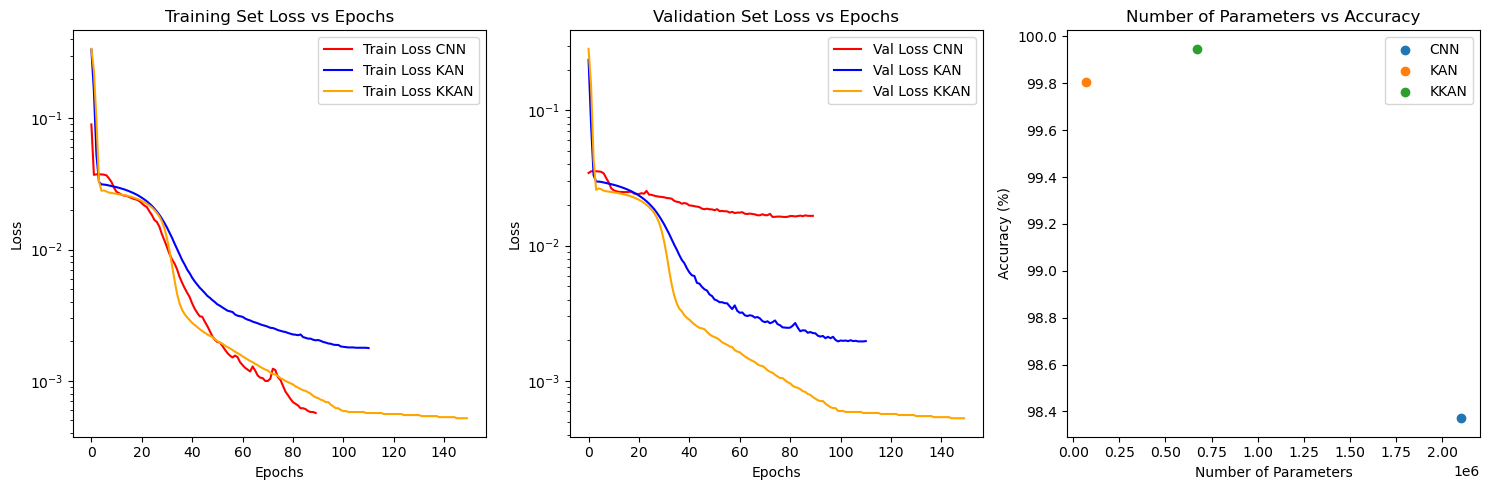

In [51]:
import pandas as pd
import glob

# Specify the folder paths
folder_path_1 = 'CNNResult/'
folder_path_2 = 'KANResult/'
folder_path_3 = 'KKANResult/'


# Use glob to get all CSV files in the folders
csv_files_1 = glob.glob(folder_path_1 + '*.csv')
csv_files_2 = glob.glob(folder_path_2 + '*.csv')
csv_files_3 = glob.glob(folder_path_3 + '*.csv')

# Print the list of CSV files to verify
print("CSV files in Result folder:", csv_files_1)
print("CSV files in KANResult folder:", csv_files_2)
print("CSV files in KKANResult folder:", csv_files_3)

# Read the CSV files
train_loss_result = pd.read_csv('CNNResult/train_loss_augmented_False.csv', header=None)
val_loss_result = pd.read_csv('CNNResult/val_loss_augmented_False.csv', header=None)

train_loss_kan = pd.read_csv('KANResult/train_loss_augmented_False.csv', header=None)
val_loss_kan = pd.read_csv('KANResult/val_loss_augmented_False.csv', header=None)

train_loss_kkan = pd.read_csv('KKANResult/train_loss_augmented_False.csv', header=None)
val_loss_kkan = pd.read_csv('KKANResult/val_loss_augmented_False.csv', header=None)

# Set the index as the epoch
train_loss_result.index = range(1, len(train_loss_result) + 1)
val_loss_result.index = range(1, len(val_loss_result) + 1)
train_loss_kan.index = range(1, len(train_loss_kan) + 1)
val_loss_kan.index = range(1, len(val_loss_kan) + 1)
train_loss_kkan.index = range(1, len(train_loss_kkan) + 1)
val_loss_kkan.index = range(1, len(val_loss_kkan) + 1)

# Transpose dataframes
train_loss_result=train_loss_result.T
val_loss_result = val_loss_result.T
train_loss_kan = train_loss_kan.T
val_loss_kan = val_loss_kan.T
train_loss_kkan = train_loss_kkan.T
val_loss_kkan = val_loss_kkan.T

# Rename the columns to 'loss'
train_loss_result.columns = ['loss']
val_loss_result.columns = ['loss']
train_loss_kan.columns = ['loss']
val_loss_kan.columns = ['loss']
train_loss_kkan.columns = ['loss']
val_loss_kkan.columns = ['loss']

# print(train_loss_result.columns)

# Print column names to verify
print("Columns in train_loss_result:", train_loss_result.columns)
print("Columns in val_loss_result:", val_loss_result.columns)
print("Columns in train_loss_kan:", train_loss_kan.columns)
print("Columns in val_loss_kan:", val_loss_kan.columns)
print("Columns in train_loss_kkan:", train_loss_kkan.columns)
print("Columns in val_loss_kkan:", val_loss_kkan.columns)

# Calculate the Accuracy
CNN_Acc= 1-val_loss_result.min().min()
KAN_Acc= 1-val_loss_kan.min().min()
KKAN_Acc= 1-val_loss_kkan.min().min()

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Loss vs Epochs training plot
ax1.plot(train_loss_result.index, train_loss_result['loss'], label='Train Loss CNN', color='red')
ax1.plot(train_loss_kan.index, train_loss_kan['loss'], label='Train Loss KAN', color='blue')
ax1.plot(train_loss_kkan.index, train_loss_kkan['loss'], label='Train Loss KKAN', color='orange')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_yscale('log')
ax1.set_title('Training Set Loss vs Epochs')
ax1.legend()

# Loss vs Epochs validation plot
ax2.plot(val_loss_result.index, val_loss_result['loss'], label='Val Loss CNN', color='red')
ax2.plot(val_loss_kan.index, val_loss_kan['loss'], label='Val Loss KAN', color='blue')
ax2.plot(val_loss_kkan.index, val_loss_kkan['loss'], label='Val Loss KKAN', color='orange')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_yscale('log')
ax2.set_title('Validation Set Loss vs Epochs')
ax2.legend()


# Number of Parameters vs Accuracy plot
# For this plot, you need to have a DataFrame or data structure containing the number of parameters and accuracy for each model
# For the sake of example, let's assume you have the following data:
models = ['CNN', 'KAN', 'KKAN']
params = [CNN_num_params, KAN_num_params, KKAN_num_params]
accuracy = [CNN_Acc*100, KAN_Acc*100, KKAN_Acc*100]

for model, param, acc in zip(models, params, accuracy):
    ax3.scatter(param, acc, label=model)

ax3.set_xlabel('Number of Parameters')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Number of Parameters vs Accuracy')
ax3.legend()

plt.tight_layout()
plt.savefig('model_comparison_plot.png')
plt.show()

In [60]:
pip install weasyprint


  Obtaining dependency information for weasyprint from https://files.pythonhosted.org/packages/0e/31/a49abf6690be72365a9df7805dd4275d7044eaef807b430d038544a3900b/weasyprint-62.1-py3-none-any.whl.metadata
  Obtaining dependency information for pydyf>=0.10.0 from https://files.pythonhosted.org/packages/f1/b3/4b87b0edaa7f2f94c131d01697f936748fc7f74c1ca9622ada372f7256e8/pydyf-0.10.0-py3-none-any.whl.metadata
  Obtaining dependency information for html5lib>=1.1 from https://files.pythonhosted.org/packages/6c/dd/a834df6482147d48e225a49515aabc28974ad5a4ca3215c18a882565b028/html5lib-1.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tinycss2>=1.3.0 from https://files.pythonhosted.org/packages/2c/4d/0db5b8a613d2a59bbc29bc5bb44a2f8070eb9ceab11c50d477502a8a0092/tinycss2-1.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for cssselect2>=0.1 from https://files.pythonhosted.org/packages/9d/3a/e39436efe51894243ff145a37c4f9a030839b97779ebcc4f13b3ba21c54e/cssselect

In [68]:
from tabulate import tabulate
# from weasyprint import HTML

# Define the data
data = {
    'Model': ['CNN', 'KAN', 'KKAN'],
    'Test Accuracy(%)': [CNN_Acc*100, KAN_Acc*100, KKAN_Acc*100],
    'Num of Parameters': [CNN_num_params, KAN_num_params, KKAN_num_params],
}

# Create a DataFrame
df = pd.DataFrame(data)

# Function to highlight the maximum values
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Function to highlight the minimum values
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: cyan' if v else '' for v in is_min]

# Apply the style only to the numerical columns
df_styled = df.style.apply(highlight_max, subset=['Test Accuracy(%)', 'Num of Parameters'], axis=0).format({'Test Accuracy(%)': '{:.3f}', 'Num of Parameters': '{:.0f}'})
df_styled = df_styled.apply(highlight_min, subset=['Test Accuracy(%)', 'Num of Parameters'], axis=0).format({'Test Accuracy(%)': '{:.3f}', 'Num of Parameters': '{:.0f}'})

# Display the table using tabulate
table = tabulate(df, headers='keys', tablefmt='grid')

# To display the styled DataFrame in Jupyter notebook
df_styled



,Model,Test Accuracy(%),Num of Parameters
0,CNN,98.371,2104003
1,KAN,99.804,67767
2,KKAN,99.947,673460


In [69]:
# Save the styled DataFrame to an HTML file
html = df_styled.to_html()
with open("styled_table.html", "w") as f:
    f.write(html)
# Convert HTML file to PDF
# HTML('styled_table.html').write_pdf('styled_table.pdf')